In [21]:
%load_ext autoreload
%autoreload 2

import atexit
import gc
import math
import os
import sys
from argparse import ArgumentParser

import numpy as np
import torch
import wandb

from src import train_utils
from src import viz
from src.dataloader import train_dataloader, val_dataloader
from src.models import PJPE, weight_init, Critic
from src.trainer import _validation_step
from src.callbacks import CallbackList, ModelCheckpoint, Logging, BetaScheduler, Analyze, MaxNorm
from src.train import training_specific_args
from collections import defaultdict
from src.processing import post_process
import src.viz.mpl_plots as plot
import sys; sys.argv=['']; del sys

# Experiment Configuration, Config, is distributed to all the other modules
parser = training_specific_args()
config = parser.parse_args()
torch.manual_seed(config.seed)
np.random.seed(config.seed)

# GPU setup
use_cuda = config.cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
config.device = device  # Adding device to config, not already in argparse
config.num_workers = 4 if use_cuda else 4  # for dataloader

# ignore when debugging on cpu
if not use_cuda:
    # os.environ['WANDB_MODE'] = 'dryrun'  # Doesnt auto sync to project
    os.environ['WANDB_TAGS'] = 'CPU'
    wandb.init(anonymous='allow', project="hpe3d", config=config)  # to_delete
else:
    os.environ['WANDB_MODE'] = 'dryrun'
    wandb.init(anonymous='allow', project="hpe3d", config=config)

config.logger = wandb
config.logger.run.save()
config.run_name = config.logger.run.name  # handle name change in wandb
# Data loading
config.train_subjects = [9, 11]
train_loader = train_dataloader(config)
config.val_subjects = [9, 11]
val_loader = val_dataloader(config)

variant = [['2d', '3d']]

models = train_utils.get_models(variant, config)  # model instances
if config.self_supervised:
    critic = Critic()
    models['Critic'] = critic
optimizers = train_utils.get_optims(variant, models, config)  # optimer for each pair
schedulers = train_utils.get_schedulers(optimizers)

# For multiple GPUs
if torch.cuda.device_count() > 1:
    print(f'[INFO]: Using {torch.cuda.device_count()} GPUs')
    for key in models.keys():
        models[key] = torch.nn.DataParallel(models[key])

# To CPU or GPU or TODO TPU
for key in models.keys():
    models[key] = models[key].to(device)
    # models[key].apply(weight_init)

config.mpjpe_min=float('inf')
config.mpjpe_at_min_val=float('inf')

config.resume_run = "rich-river-2471"
# initiate all required callbacks, keep the order in mind!!!
cb = CallbackList([ModelCheckpoint(),
                    Logging(),                       
                    BetaScheduler(config, strategy="cycling"),
                    Analyze(500)])

cb.setup(config = config, models = models, optimizers = optimizers,
            train_loader = train_loader, val_loader = val_loader, variant = variant)

n_pair=1
pair=variant[0]
vae_type="_2_".join(pair)
# model -- encoder, decoder / critic
model=[models[f"Encoder{pair[0].upper()}"],
            models[f"Decoder{pair[1].upper()}"]]
optimizer = [optimizers[n_pair]]
scheduler = [schedulers[n_pair]]

if config.self_supervised:
    model.append(models['Critic'])
    optimizer.append(optimizers[-1])
    scheduler.append(schedulers[-1])


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
[INFO]: Training data loader called
[INFO]: processing subjects: [9, 11]
samples - 109867
[INFO]: Validation data loader called
[INFO]: processing subjects: [9, 11]
samples - 109867
[INFO] Loaded Checkpoint rich-river-2471: Encoder2D @ epoch 6
[INFO] Loaded Checkpoint rich-river-2471: Decoder3D @ epoch 6
[INFO] Loaded Checkpoint rich-river-2471: critic @ epoch 6
[INFO]: Start training procedure using device: cuda
[INFO]: Analyze Callback. using rich-river-2471
[INFO]: Analyze Callback. Skip training
Updated Validation Samples - 500


In [22]:
# Validation epoch code

cb.on_validation_start()

t_data = defaultdict(list)
loss_dic = defaultdict(int)
normalize_pose = True
epoch = 1
with torch.no_grad():
    for batch_idx, batch in enumerate(val_loader):
        for key in batch.keys():
            batch[key] = batch[key].to(config.device)

        output = _validation_step(batch, batch_idx, model, epoch, config)

        loss_dic['loss'] += output['loss'].item()
        loss_dic['recon_loss'] += output['log']['recon_loss'].item()
        loss_dic['kld_loss'] += output['log']['kld_loss'].item()

        if config.self_supervised:
            loss_dic['critic_loss'] += output['log']['critic_loss'].item()
            loss_dic['critic_loss_real'] += output['log']['critic_loss_real'].item()
            loss_dic['critic_loss_fake'] += output['log']['critic_loss_fake'].item()

        for key in output['data'].keys():
            t_data[key].append(output['data'][key])

        del output
        gc.collect()

avg_loss = loss_dic['loss']/len(val_loader)  # return for scheduler

for key in t_data.keys():
    t_data[key] = torch.cat(t_data[key], 0)

# performance
if '3D' in model[1].name:
    if normalize_pose and not config.self_supervised:
        t_data['recon_3d'], t_data['target_3d'] = post_process(
            t_data['recon_3d'], t_data['target_3d'])

    elif config.self_supervised:
        t_data['recon_3d'], t_data['target_3d'] = post_process(
            t_data['recon_3d'].to('cpu'), t_data['target_3d'].to('cpu'),
            scale=t_data['scale_3d'].to('cpu'),
            self_supervised=True, procrustes_enabled=False)

    # Speed up procrustes alignment with CPU!
    t_data['recon_3d']=t_data['recon_3d'].to('cuda')
    t_data['target_3d']=t_data['target_3d'].to('cuda')

    pjpe = PJPE(t_data['recon_3d'], t_data['target_3d'])
    avg_pjpe = torch.mean((pjpe), dim=0)
    avg_mpjpe = torch.mean(avg_pjpe).item()
    pjpe = torch.mean(pjpe, dim=1)

    config.logger.log({"pjpe": pjpe.cpu()})

cb.on_validation_end(config=config, vae_type=vae_type, epoch=epoch, loss_dic=loss_dic,
                        val_loader=val_loader, mpjpe=avg_mpjpe, avg_pjpe=avg_pjpe, pjpe=pjpe,                               t_data=t_data)

Start validation epoch
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2d_2_3d Validation: 		Loss: 0.0216 	ReCon: 0.0021 	KLD: 2.6579	Critic: 0.6312	Critic Real: 0.6313	Critic Fake: 0.7669
2d_2_3d - * MPJPE * : 2257.7156 
 tensor([   0.0000, 2584.2986, 1794.5503, 1335.4475, 3091.5242, 2850.1343,
        1684.5071, 3555.6292, 3359.8159, 1602.8572, 3319.9333, 3515.6104,
        2236.0110, 1766.5702, 2890.0947, 1866.1016,  928.0768],
       device='cuda:0')


<Figure size 305x305 with 0 Axes>

In [23]:
t_data['recon_3d'].device

device(type='cuda', index=0)

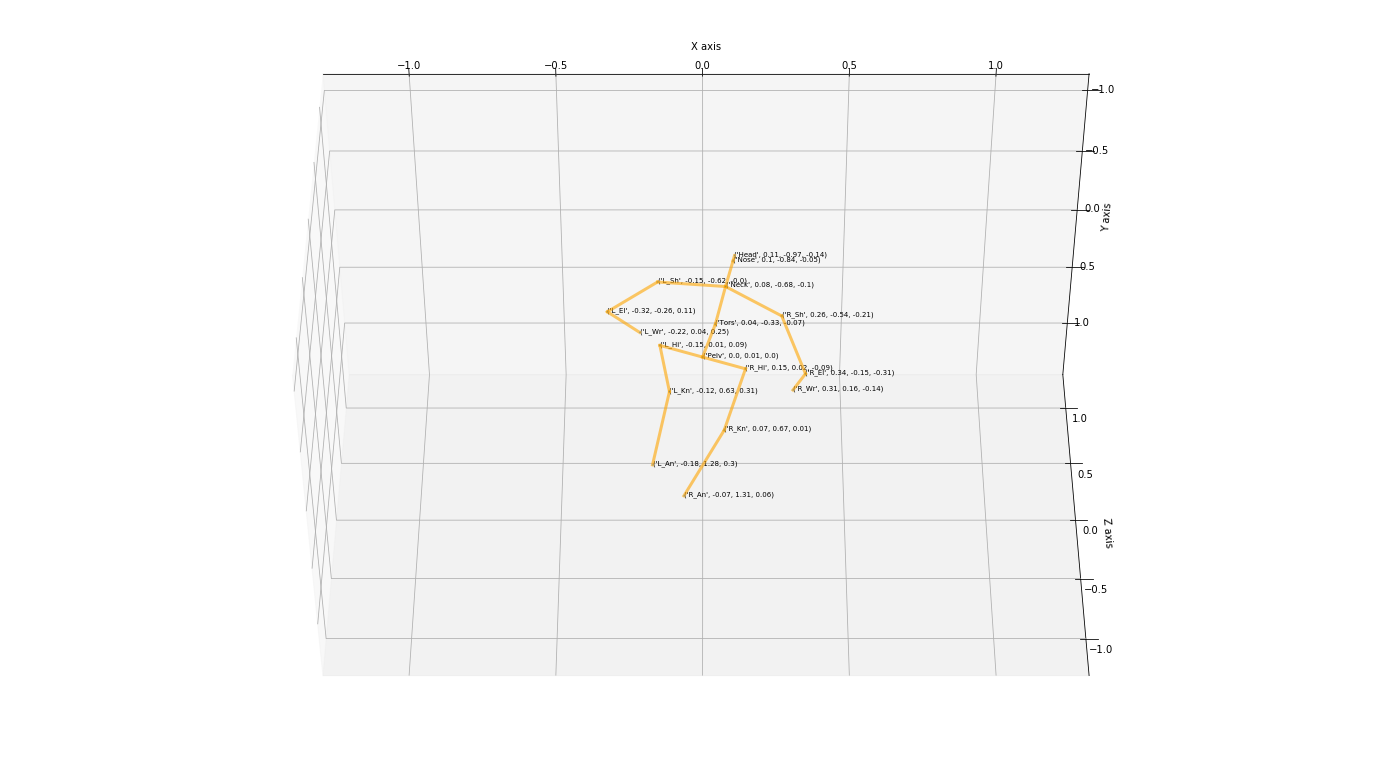

array([714.45306], dtype=float32)

In [33]:
%matplotlib inline
_3d = t_data["target_3d"][0].cpu().numpy()
_2d = t_data['recon_2d'][0].cpu().numpy()
_scale = t_data['scale_3d'][0].cpu().numpy()
_3d = _3d/_scale
plot.plot_3d(_3d, color='orange', mode="show",
                show_ticks=True, labels=True, mean_root=True)
# plot.plot_2d(_2d)
_scale

In [ ]:
_3d = 